In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost, relative_entropy_control_cost_direct
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

## Variance and Mean Matching bug Here

Check out ln_prior there I am tweaking $\sigma_w$ Ive set the log_likelihood to be 0 this way our algorithm should be trying to have as target the prior . For some reason the neural net is completely unable to match the variance I am specifying I have gone from very low to very high and the method is unable to do anhything to fit the target variance. For a sufficiently small $\Delta t$ we should be able to do this, standard VI is able to do this, so theres some sort of bug / issue here. 

UPDATE: Atm its not even matching the mean hardcoded it to 10 and nothings happening ?? whats going on here?

In [19]:
# TODO: Why is changing σ_w doing nothing ??
def ln_prior(Θ, σ_w=20.1):
    """
    Prior for means in Bayesian GMM
    """
    return -0.5 * ((Θ-10)**2).sum(axis=1) / σ_w

In [20]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim =  2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [21]:
relative_entropy_control_cost_direct(sde, Θ_0, ln_prior, γ=1.0, device=device)

tensor(4.3060, device='cuda:0', grad_fn=<MeanBackward0>)

In [22]:
γ = 1.0
Δt=0.005
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.01, weight_decay =0.1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 300

train = True
if train:
    for i in tqdm(range(num_steps)):
        optimizer.zero_grad()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                loss = relative_entropy_control_cost_direct(
                    sde, Θ_0.float(),
                    ln_prior, γ=γ
                )
                optimizer.zero_grad()
                loss.backward()
                return loss

            optimizer.step(closure)
            losses.append(closure().item())
        else:
            loss = relative_entropy_control_cost_direct(
                sde, Θ_0,
                ln_prior, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            losses.append(loss.item())

200


  0%|          | 0/300 [00:00<?, ?it/s]

In [23]:
losses

[4.981014251708984,
 4.16414213180542,
 4.033440589904785,
 3.9418749809265137,
 3.937480926513672,
 3.948842763900757,
 4.18925142288208,
 4.125405311584473,
 4.1920013427734375,
 3.873631000518799,
 4.078127384185791,
 4.256169319152832,
 3.9560298919677734,
 4.120203018188477,
 3.841951608657837,
 4.384714126586914,
 4.023187160491943,
 4.065535068511963,
 4.080394744873047,
 3.922161102294922,
 3.8584001064300537,
 4.101004123687744,
 4.135249137878418,
 4.117086887359619,
 4.27208137512207,
 4.154797077178955,
 3.9840736389160156,
 3.6834051609039307,
 4.144225597381592,
 4.0798211097717285,
 4.210195541381836,
 4.193254470825195,
 4.173996925354004,
 3.958299160003662,
 3.9377782344818115,
 3.9994451999664307,
 3.875392436981201,
 4.057377815246582,
 4.097256183624268,
 4.190518856048584,
 3.90537691116333,
 3.988774538040161,
 3.9740405082702637,
 3.9373350143432617,
 4.37684440612793,
 4.278815746307373,
 4.007426738739014,
 4.122635841369629,
 4.143807411193848,
 4.09637212753

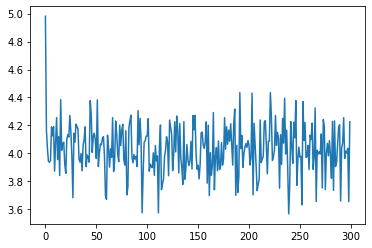

In [24]:
plt.plot(losses[:])

In [25]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([200, 50, 2])

In [26]:
torch.eye(3,2)

tensor([[1., 0.],
        [0., 1.],
        [0., 0.]])

In [27]:
# Mannualy doing one step of Euler

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

In [28]:
Θ_1 = Θ_1.reshape(50,2)

(array([ 1.,  0.,  5.,  7.,  9., 11.,  6.,  7.,  1.,  3.]),
 array([-2.3072743 , -1.8471565 , -1.3870386 , -0.9269208 , -0.4668029 ,
        -0.00668502,  0.45343286,  0.91355073,  1.3736686 ,  1.8337865 ,
         2.2939043 ], dtype=float32),
 <a list of 10 Patch objects>)

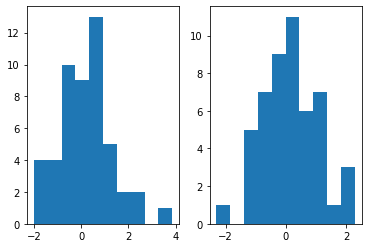

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(Θ_1[:,0].flatten().cpu().detach().numpy())
ax2.hist(Θ_1[:,1].flatten().cpu().detach().numpy())

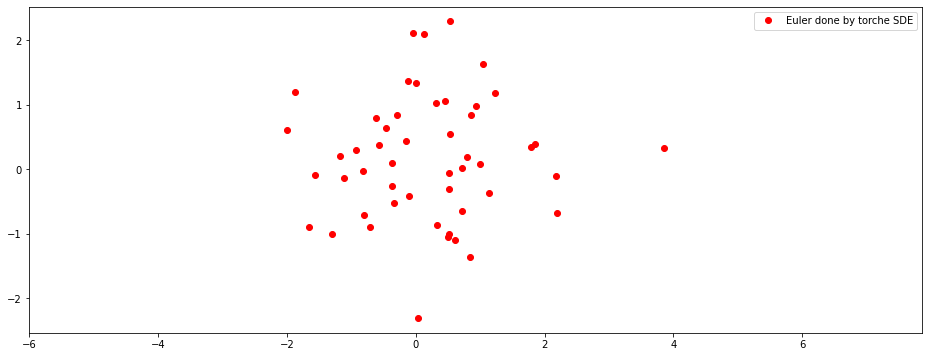

In [32]:
fig, ax_1 = plt.subplots(1, 1, figsize=(16, 6))
Θ_plot = Θ_1.cpu().detach() #.reshape(50*3,2)

# Θ_plot2 = Θ_2.cpu().detach() 



ax_1.plot(Θ_plot[:, 0], Θ_plot[:, 1], 
         linestyle='none', 
         marker='o', color="red", label="Euler done by torche SDE")

# ax_1.plot(Θ_plot2[:, 0], Θ_plot2[:, 1], 
#          linestyle='none', 
#          marker='o', color="blue", label="Euler done manually")

# ax_1.plot(X_scaled[:, 0], X_scaled[:, 1], 
#          linestyle='none', 
#          marker='o', label="Observations $X$")

ax_1.legend()
ax_1.axis('equal');